# Beatomizer

### 0.1 Importing Files

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, RepeatVector, Concatenate, Activation, Dot, Conv1D, MaxPooling1D, GRU, BatchNormalization, Flatten, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import math
import cv2

### 0.2 Some Hyperparameters

In [3]:
SAVE_PATH = "./YoutubeVideos"
AUDIO_PATH = "./AudioFiles"
VISUALIZER_PATH = "./Visualizers"
outputFrameRate = 60.0
maximumMinuteDuration = 0.25
minimumSecondDuration = 3

learning_rate = 0.005
learning_rate1D = 0.01

n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(3)

2022-12-09 19:07:37.292329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1 Dataset

### 1.1 Loading in the Youtube Videos

In [4]:
from pytube import YouTube
from moviepy.editor import VideoFileClip

links = ["https://www.youtube.com/watch?v=RDlMvJb0QGA", 
         "https://www.youtube.com/watch?v=90oZ52M4IC0",
         "https://www.youtube.com/watch?v=uwk-XskXCI4",
         "https://www.youtube.com/watch?v=TQOCdulydlY",
         "https://www.youtube.com/watch?v=Go2NOmWpuoE",
         "https://www.youtube.com/watch?v=Hsk5romLo-U",
         "https://www.youtube.com/watch?v=Yd5_VFar5YM",
         "https://www.youtube.com/watch?v=OQVeDDf4T-4",
         "https://www.youtube.com/watch?v=UAwDpvZEn1g",
         "https://www.youtube.com/watch?v=9EDRVwlW9zQ",
         "https://www.youtube.com/watch?v=HAFVJAKpzFk",
         "https://www.youtube.com/watch?v=JOPIKFJ4W6Y",
         "https://www.youtube.com/watch?v=NZz2ksOmbuQ",
         "https://www.youtube.com/watch?v=Cm4PJ023iXI",
         "https://www.youtube.com/watch?v=NSmj4yV0zZM",
         "https://www.youtube.com/watch?v=hk-pBKXbAds",
         "https://www.youtube.com/watch?v=hbn3aU7Uscg",
         "https://www.youtube.com/watch?v=C5-LvuSPuew"]
filenames = []

nameIndex = 0
for link in links:
    try:
        yt = YouTube(link)
    except:
        print("Connection Error")
        
    mp4files = yt.streams.filter(file_extension="mp4")
    mp4360pfiles = mp4files.get_by_resolution("360p")
    
    try:
        filename = str(nameIndex) + ".mp4"
        mp4360pfiles.download(SAVE_PATH, filename=filename)

        desiredFile = SAVE_PATH + "/" + filename
        audioFile = str(nameIndex) + ".mp3"
        newFile = AUDIO_PATH + "/" + audioFile

        clip = VideoFileClip(desiredFile)
        clip.audio.write_audiofile(newFile, verbose=False, logger=None)

        filenames.append([filename, audioFile])
        nameIndex += 1
    except:
        print("Some Error")

### 1.2 Generating data from the videos

In [5]:
visualizerFrameSize = (500, 500)

# Helper function to convert a list of rgb values (with frame rate given above) into a visualization
def visualize(rgbValues, index):
    out = cv2.VideoWriter(VISUALIZER_PATH + "/output_" + index + ".mp4", cv2.VideoWriter_fourcc(*'mp4v'), outputFrameRate, visualizerFrameSize)
    
    for val in rgbValues:
        val = val.astype(np.uint8)
        img = np.dstack((np.full(visualizerFrameSize, val[0]), np.full(visualizerFrameSize, val[1]), np.full(visualizerFrameSize, val[2])))
        out.write(img)
        
    out.release()

In [6]:
# Helper function to upscale the youtube videos to the desired frame rate (and divide up the audio accordingly)
def createScaling(index, desiredFrames, inputtedFrames, depth=5):
    if (depth == 0):
        return 0

    total = 0
    totalFramesLeft = desiredFrames
    while (totalFramesLeft > inputtedFrames):
        total += 1
        totalFramesLeft -= inputtedFrames
    
    if (totalFramesLeft - inputtedFrames == 0):
        total += 1
        return total
    elif (totalFramesLeft == 0):
        return total
    else:
        if (totalFramesLeft/inputtedFrames) > 0.5:
            total += 1
            floor = math.floor(inputtedFrames/(inputtedFrames - totalFramesLeft))
            if (index % floor == 0):
                total -= 1
            remainingFramesToNegate = math.floor(((inputtedFrames - ((inputtedFrames - totalFramesLeft) * floor))/floor) + 1)
            #remainingFramesToNegate = (((inputtedFrames/(inputtedFrames - totalFramesLeft)) - floor) * (inputtedFrames - totalFramesLeft) * floor)/floor
            return total + createScaling(index, remainingFramesToNegate, inputtedFrames, depth=depth-1)
        else:
            floor = math.floor(inputtedFrames/totalFramesLeft)
            if (index % floor == 0):
                total += 1
            remainingFramesToNegate = math.floor(((inputtedFrames - (totalFramesLeft * floor))/floor))
            return total - createScaling(index, remainingFramesToNegate, inputtedFrames, depth=depth-1)

In [7]:
# Finds the maximum length vectors so that we can pad all vectors to the same length
def findMaximumforPadding(x, y):
    largestExample = 0
    largestVectorSize = 0
    for example in x:
        if len(example) > largestExample:
            largestExample = len(example)
        for vector in example:
            if len(vector) > largestVectorSize:
                largestVectorSize = len(vector)
    return largestExample, largestVectorSize

In [8]:
import librosa

# whichToVisualize is an array of indexes representing which videos to generate visualizers for
# maximumLength is in minutes, representing the maximum length of a particular sample
def generateData(filenames, whichToVisualize=None, maximumLength=maximumMinuteDuration, testData=False, largestE=None, largestV=None):
    x = []
    y = []
    currentVisualizerIndex = 0
    for filename, audiofilename in filenames:
        video = cv2.VideoCapture(SAVE_PATH + "/" + filename)
        
        # Parse important info from the video
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = video.get(cv2.CAP_PROP_FPS)
        videoLength = frame_count/fps
        scaling = outputFrameRate/fps
        print("# of Original Frames:", frame_count)
        print("# of Desired Frames:", int(frame_count * scaling))
        print("Original Frame Rate:", fps)
        print("Desired Frame Rate:", outputFrameRate)
        
        # Calculate the maximum frames allowed for a particular sample
        maxFrames = int(maximumLength * 60 * fps)
        print("Max Frames: ", maxFrames)
        print("Desired Frames: ", maxFrames * scaling)
        
        # Load in the audio
        data, sr = librosa.load(AUDIO_PATH + "/" + audiofilename)
        audioPosition = 0
        print("# Audio Samples:", len(data))
        print("")
        
        frameIndex = 0
        
        xOutput = []
        yOutput = []
        
        while (video.isOpened()):
            ret, frame = video.read()
            if ret == False:
                break
            
            framesToCreate = createScaling(frameIndex, int(frame_count * scaling), frame_count)
            audioValuesToCombine = createScaling(frameIndex, len(data), int(frame_count * scaling)) 
            audioForFrame = np.asarray(data[audioPosition:audioValuesToCombine+audioPosition])
            audioPosition += audioValuesToCombine
            
            for _ in range(framesToCreate):
                val = np.mean(frame, axis=0)
                val = np.mean(val, axis=0)
                yOutput.append(val)
                xOutput.append(audioForFrame)
                
            frameIndex += 1
            if (frameIndex % maxFrames == 0 or frameIndex == frame_count):
                y.append(yOutput)
                x.append(xOutput)
                
                if (whichToVisualize != None):
                    if (currentVisualizerIndex < len(whichToVisualize)):
                        if (str(whichToVisualize[currentVisualizerIndex]) + ".mp4" == filename):
                            visualize(yOutput, str(whichToVisualize[currentVisualizerIndex]))
                            currentVisualizerIndex += 1
                        
                yOutput = []
                xOutput = []
            
        video.release()
    cv2.destroyAllWindows()
        
    # Weed out small examples
    for i in range(len(y)-1, -1, -1):
        if len(y[i]) < minimumSecondDuration * outputFrameRate:
            del y[i]
            del x[i]
            
    # Find the largest size vector (except in the case where we already know the largest size vector, i.e. testing)
    largestExample = 0
    largestVectorSize = 0
    if not testData:
        largestExample, largestVectorSize = findMaximumforPadding(x, y)
    else:
        largestExample = largestE
        largestVectorSize = largestV
    
    # Add the actual padding here
    for exampleIndex in range(len(x)):
        # Iterate over all vectors in the example
        iterationIndex = 0
        while iterationIndex <= largestExample:
            if iterationIndex > len(x[exampleIndex]):
                x[exampleIndex].append(np.zeros((largestVectorSize,)))
                y[exampleIndex].append(np.zeros((3,)))
            else:
                for vectorIndex in range(len(x[exampleIndex])):
                    while len(x[exampleIndex][vectorIndex]) < largestVectorSize:
                        x[exampleIndex][vectorIndex] = np.append(x[exampleIndex][vectorIndex], [0])
            iterationIndex += 1
    
    print(largestExample)
    print(largestVectorSize)
            
    x = np.asarray(x)
    y = np.asarray(y)
    #y = list(y.swapaxes(0,1))
    
    return x, y, largestExample, largestVectorSize

In [9]:
x, y, largestTx, largestVectorSize = generateData(filenames, [0, 1])

# of Original Frames: 3056.0
# of Desired Frames: 7640
Original Frame Rate: 24.0
Desired Frame Rate: 60.0
Max Frames:  360
Desired Frames:  900.0
# Audio Samples: 2807847

# of Original Frames: 19926.0
# of Desired Frames: 39891
Original Frame Rate: 29.97002997002997
Desired Frame Rate: 60.0
Max Frames:  449
Desired Frames:  898.8980000000001
# Audio Samples: 14660604

# of Original Frames: 19778.0
# of Desired Frames: 39556
Original Frame Rate: 30.0
Desired Frame Rate: 60.0
Max Frames:  450
Desired Frames:  900.0
# Audio Samples: 14537785

# of Original Frames: 10932.0
# of Desired Frames: 21885
Original Frame Rate: 29.97
Desired Frame Rate: 60.0
Max Frames:  449
Desired Frames:  898.898898898899
# Audio Samples: 8043620

# of Original Frames: 6153.0
# of Desired Frames: 14767
Original Frame Rate: 25.0
Desired Frame Rate: 60.0
Max Frames:  375
Desired Frames:  900.0
# Audio Samples: 5427167

# of Original Frames: 12735.0
# of Desired Frames: 25495
Original Frame Rate: 29.9700299700299

## 2 Model

### 2.1 Baseline (Convolutional neural network)

In [58]:
def oneDConvNet(Tx, Ty, audioValuesPerFrame):
    # The model takes as input vectors of size (Tx, audioValuesPerFrame) which can be thought of as a picture
    X_inputs = Input(shape=(Tx, audioValuesPerFrame))
    
    # Convolutional 1D layer
    X = Conv1D(filters=130, kernel_size=13, strides=2)(X_inputs)
    X = Activation("relu")(X)
    X = MaxPooling1D(pool_size=2)(X)
    
    # Second Convolutional 1D Layer
    X = Conv1D(filters=150, kernel_size=10, strides=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling1D(pool_size=2)(X)
    
    # Third Convolutional 1D Layer
    X = Conv1D(filters=170, kernel_size=7, strides=4)(X)
    X = Activation("relu")(X)
    X = MaxPooling1D(pool_size=3)(X)
    
    # Fourth Convolutional 1D Layer
    X = Conv1D(filters=200, kernel_size=4, padding='same')(X)
    X = Activation("relu")(X)
    X = MaxPooling1D(pool_size=2)(X)
    X = Flatten()(X)
    
    # Dense layers
    X = Dense(2048)(X)
    X = Dense(1024)(X)
    X = Dense(512)(X)
    X = Dense(Ty)(X)
    
    model = Model(inputs=X_inputs, outputs=X)
    
    return model

In [59]:
oneDModel = oneDConvNet(largestTx, largestTx * 3, largestVectorSize)

In [66]:
opt = Adam(lr=learning_rate1D, beta_1=0.9, beta_2=0.999, decay=0.01)
oneDModel.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[tf.keras.metrics.CosineSimilarity(axis=1)])

In [67]:
# Reshape y for this problem (so dense layer can have the valid output)
yReshaped = np.asarray(y)
yReshaped = yReshaped.reshape(yReshaped.shape[0], yReshaped.shape[1] * yReshaped.shape[2])

In [68]:
historyOneD = oneDModel.fit(x, yReshaped, epochs=20, batch_size=3, validation_split=0.1)

Epoch 1/20
201/201 [==============================] - 11s 51ms/step - loss: 2930.0959 - cosine_similarity: 0.7157 - val_loss: 1541.0325 - val_cosine_similarity: 0.7550
Epoch 2/20
201/201 [==============================] - 9s 45ms/step - loss: 2577.1853 - cosine_similarity: 0.7594 - val_loss: 1186.4834 - val_cosine_similarity: 0.7666
Epoch 3/20
201/201 [==============================] - 9s 45ms/step - loss: 2542.2449 - cosine_similarity: 0.7607 - val_loss: 1214.1298 - val_cosine_similarity: 0.7607
Epoch 4/20
201/201 [==============================] - 9s 45ms/step - loss: 2521.4409 - cosine_similarity: 0.7612 - val_loss: 1175.9274 - val_cosine_similarity: 0.7659
Epoch 5/20
201/201 [==============================] - 9s 46ms/step - loss: 2515.0952 - cosine_similarity: 0.7613 - val_loss: 1263.7609 - val_cosine_similarity: 0.7617
Epoch 6/20
201/201 [==============================] - 10s 47ms/step - loss: 2490.7161 - cosine_similarity: 0.7614 - val_loss: 1358.4802 - val_cosine_similarity: 0.7

### 2.2 Attention Model

#### 2.2.1 Define loss and layers to be used

In [15]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [16]:
repeator = RepeatVector(largestTx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation("softmax", name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes=1)

In [17]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    return context

In [18]:
def audioToVideoTranslator(Tx, Ty, n_a, n_s, audioValuesPerFrame):
    X = Input(shape=(Tx, audioValuesPerFrame))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = c0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    for t in range(Ty):
        
        context = one_step_attention(a, s)
        
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])
        
        out = output_layer(inputs=s)
        
        outputs.append(out)
        
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

#### 2.2.2 Generate the model

In [95]:
testModel = audioToVideoTranslator(largestTx, largestTx, n_a, n_s, largestVectorSize)

In [96]:
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=0.01)
testModel.compile(loss=custom_loss, optimizer=opt, metrics=[tf.keras.metrics.LogCoshError()])

In [97]:
s0 = np.zeros((len(x), n_s))
c0 = np.zeros((len(x), n_s))

In [ ]:
testModel.fit([x, s0, c0], list(y.swapaxes(0,1)), epochs=2, batch_size=3, validation_split=0.1)

Epoch 1/2


## 3 Testing Model / Visualizing Output

### 3.1 Define helper functions to visualize the output

In [19]:
import matplotlib.pyplot as plt

def graphIntensity(rgbValues):
    xCoordinates = np.arange(len(rgbValues))
    yCoordinates = []
    for rgbValue in rgbValues:
        yCoordinates.append(np.dot(rgbValue, rgbValue))
    
    plt.plot(xCoordinates, yCoordinates)
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    
    plt.show()

### 3.2 Generate the examples we are going to use

In [20]:
exampleLinks = ["https://www.youtube.com/watch?v=aNggrPAi5dg"]
exampleFileNames = []

nameIndex = 0
for link in exampleLinks:
    try:
        yt = YouTube(link)
    except:
        print("Connection Error")
        
    mp4files = yt.streams.filter(file_extension="mp4")
    mp4360pfiles = mp4files.get_by_resolution("360p")
    
    try:
        filename = "example" + str(nameIndex) + ".mp4"
        mp4360pfiles.download(SAVE_PATH, filename=filename)

        desiredFile = SAVE_PATH + "/" + filename
        audioFile = "example" + str(nameIndex) + ".mp3"
        newFile = AUDIO_PATH + "/" + audioFile

        clip = VideoFileClip(desiredFile)
        clip.audio.write_audiofile(newFile, verbose=False, logger=None)
        
        exampleFileNames.append([filename, audioFile])
        nameIndex += 1
    except:
        print("Some Error")

In [21]:
xTest, _, maxVal, maxVal2 = generateData(exampleFileNames, testData=True, largestE=largestTx, largestV=largestVectorSize)

# of Original Frames: 4923.0
# of Desired Frames: 11815
Original Frame Rate: 25.0
Desired Frame Rate: 60.0
Max Frames:  375
Desired Frames:  900.0
# Audio Samples: 4342748

902
369


### 3.3 Test the models / Run the examples on the model

In [91]:
predict1D = oneDModel.predict(np.expand_dims(xTest[0], axis=0))

reshapedPrediction1D = predict1D.reshape(902, 3)

1/1 [==============================] - 0s 39ms/step


In [92]:
visualize(reshapedPrediction1D, "1DVisualization")

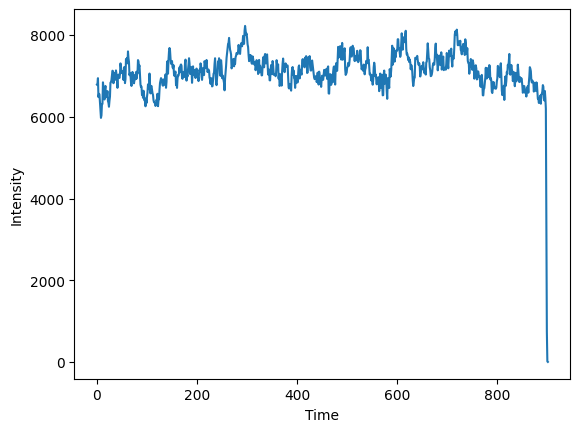

In [93]:
graphIntensity(reshapedPrediction1D)

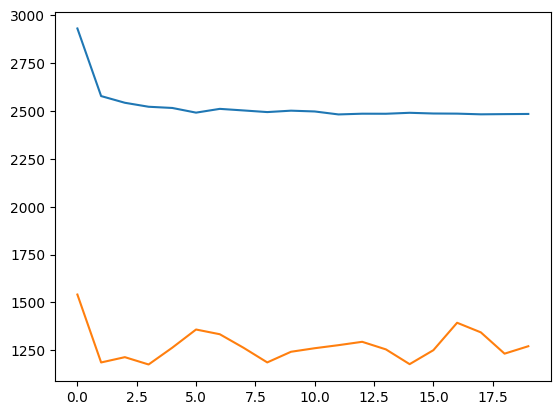

In [94]:
plt.plot(historyOneD.history['loss'])
plt.plot(historyOneD.history['val_loss'])
plt.show()

In [ ]:
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
prediction = testModel.predict([np.expand_dims(xTest[3], axis=0), s00, c00])

In [ ]:
visualize(np.squeeze(prediction), "AttentionVisualization")

In [ ]:
graphIntensity(np.squeeze(prediction))